In [1]:
#pip install more-itertools
import unidecode
import fitz
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from more_itertools import sort_together
import re
import numpy as np
import os


class ReadPDF:
    ''' clase para lectura de PDF demandado
    por Cristian barria, esta clase esta pensada para leer
    una o mas paginas de un PDF limpiando el texto menos
    relevante'''
    
    def __init__(self, file=None, special_cases=None, **kwrgs):
        self.special_cases = special_cases
        self.special_counter = {}
        self.path2pdf = file
        self.pages = fitz.open(self.path2pdf)
        self.lenpages = len(self.pages)
        self.checks = open('checks.txt').readlines()[0].split(',')
    
    def lower_str(self, x: str):
        if isinstance(x, str):
            return x.lower()
        return x
    
    def deunicode_str(self, x: str):
        if isinstance(x, str):
            return unidecode.unidecode(x)
        return x

    def lower_and_unicode(self, text):
        text = list(map(self.lower_str, text))
        text = list(map(self.deunicode_str, text))
        return text

    def remove_less_than3(self, text):
        return [word for word in text if len(word) > 3]
    
    def clean_checks(self, text):
        return [word for word in text if not word in self.checks]
    
    def repair_cuts(self, keywords):
        for i, word in enumerate(keywords):
            if word.endswith('-'):
                trated = word.split('-')[0]
                target_word = keywords[i + 1]
                trated += target_word
                keywords.append(trated)

        # removimos palabras vacias
        for i, word in enumerate(keywords):
            if word.endswith('-'):
                keywords[i] = None

        keywords = [word for word in keywords if word]
        
        return keywords
    
    def alphanumeric(self, text):
        return [word for word in text if word.isalnum()]
    def on_special_cases(self, text):
        all_text = ''.join(text)
        if self.special_cases:
            for case in self.special_cases:
                if ' ' in case:
                    old_case = case
                    case = ''.join(case.split(' '))
                else:
                    old_case = case
                self.special_counter[old_case] = len(re.findall(case, all_text))

    def __call__(self, pages=None, **kwrgs):
        text = ''
        if isinstance(pages, list):
            for page in pages:
                try:
                    text += self.pages[page].get_text()
                except:
                    print(page)
        
        elif isinstance(pages, int):
            text += self.pages[pages].get_text()
        
        elif not pages:
            for page in range(len(self.pages)):
                text += self.pages[page].get_text()
        text = word_tokenize(text)
        text = self.lower_and_unicode(text)
        text = self.repair_cuts(text)
        self.on_special_cases(text)
        text = self.remove_less_than3(text)
        text = self.clean_checks(text)
        text = self.alphanumeric(text)
        return text

In [2]:
def plot_words(words, special_cases: dict ,figsize=(12, 7), title='', repetitions=8,
               target=False, target_words=None, **kwargs):
    ''' funcion que permite vizualizar rapidamente
    graficos de tendencias de palabras en una lista de palabras'''
    inter, val = 'internacionalizacion', words.count('internacionalizacion')
    if not target:
        counter = dict(Counter(words))
        target_words = []
        for key, count in counter.items():
            if count < repetitions:
                target_words.append(key)

        for word in target_words:
            words = list(filter((word).__ne__, words))

        counter = dict(Counter(words))

    else:
        counter = {} 
        for t in target_words:
            counter[t] = words.count(t)
    mean = np.mean(list(counter.values()))
    counter[inter] = val
    if special_cases:
        for key, val in special_cases.items():
            counter[key] = val
    
    x = list(counter.keys())
    y = list(counter.values())
    y, x = sort_together([y, x], reverse=True)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    bars = ax.bar(x=x, height=y, color='0.7')
    ### number on top ####
    ax.bar_label(bars)
    ######################
    ax.axhline(mean, color='Red')
    ax.set_yticks([mean])
    ax.bar(x='internacionalizacion', height=counter['internacionalizacion'], color='Red')
    ax.bar(x=list(special_cases.keys()), height=list(special_cases.values()), color='Purple')
    ax.set_title(title, fontsize=18)
    ax.tick_params(axis='x', labelrotation=20)
    plt.xticks(ha='right')
    plt.savefig(f'{title}.png', dpi=270)
    plt.show()

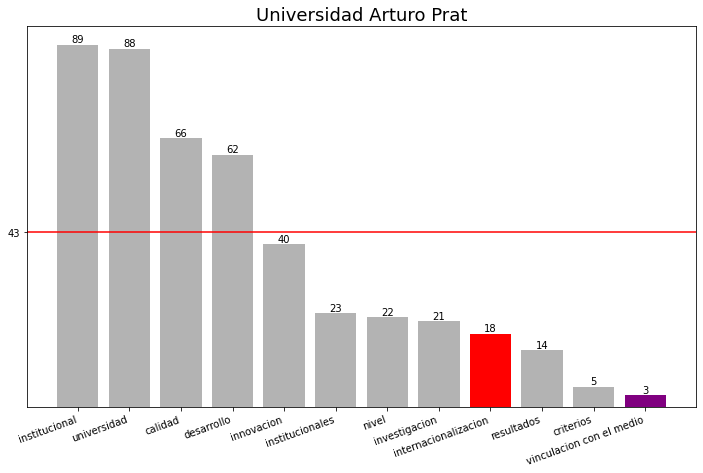

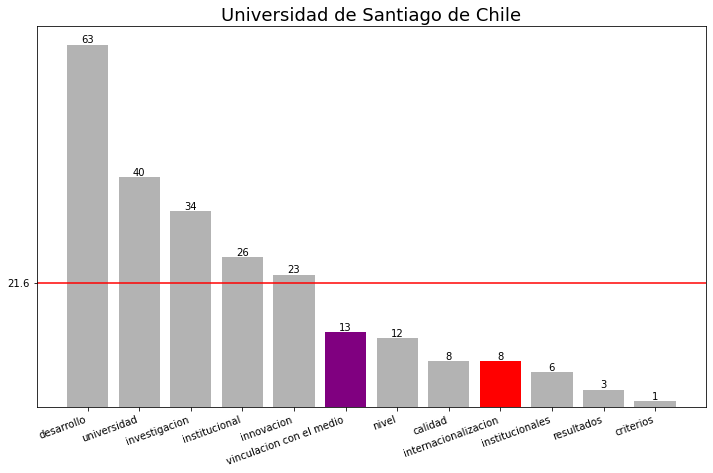

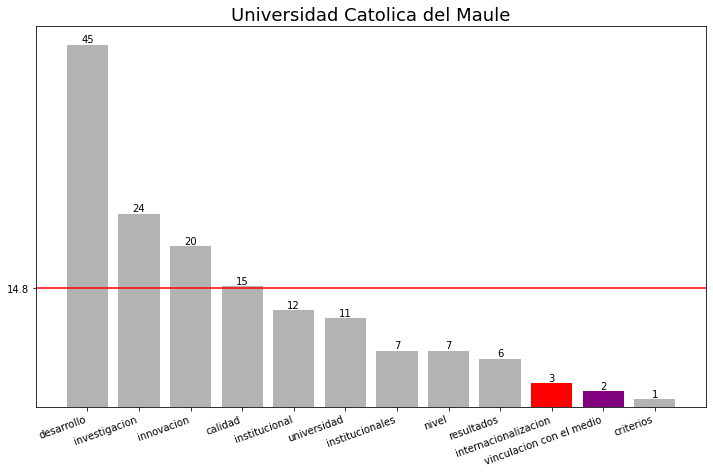

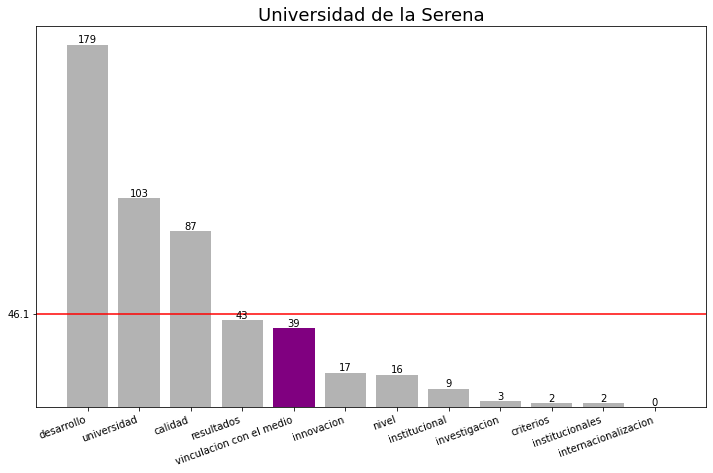

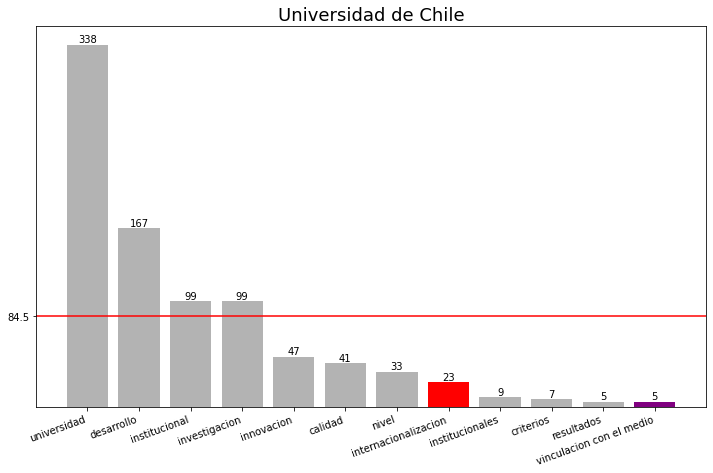

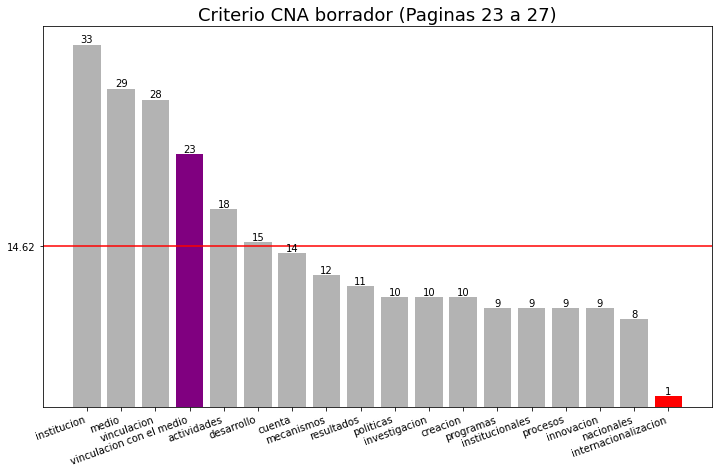

In [3]:
target_words = [
     'criterios',
     'calidad',
     'institucional',
     'resultados',
     'investigacion',
     'innovacion',
     'institucionales',
     'desarrollo',
     'nivel',
     'universidad']

special_cases = ['vinculacion con el medio']

task = [{'file': 'plan_estrategico_institucional_2020_2025_v11_2021.pdf', 'target': True,
         'title': 'Universidad Arturo Prat', 'special_cases': special_cases},
        
        {'file': 'PEI_INSTITUCIONAL_2020-2030.pdf', 'target': True,
         'title': 'Universidad de Santiago de Chile', 'special_cases': special_cases},
        
        {'file': 'PDE-Universidad-Catolica-Del-Maule.pdf', 'target': True,
         'title': 'Universidad Catolica del Maule', 'special_cases': special_cases},
        
        {'file': 'plan-estrategico-de-desarrollo-uls-2016-2020-.pdf', 'target': True,
         'title': 'Universidad de la Serena', 'special_cases': special_cases},
        
        {'file': 'plan-de-desarrollo-institucionalweb.pdf', 'target': True,
         'title': 'Universidad de Chile', 'special_cases': special_cases},
        # 
        {'file': 'Cirterios CNA_borrador.pdf', 'target': False, 'pages': list(range(22, 28)),
         'title': 'Criterio CNA borrador (Paginas 23 a 27)', 'special_cases': special_cases}]

for t in task:
    pdf = ReadPDF(**t)
    words = pdf(**t)
    plot_words(words,
               title=t['title'],
               special_cases=pdf.special_counter,
               target=t['target'],
               target_words=target_words)

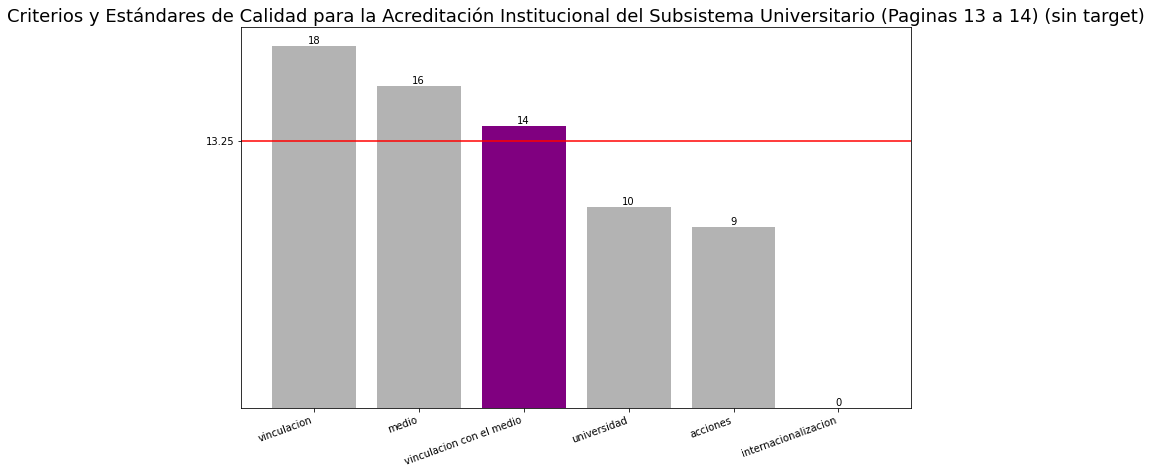

In [4]:
task = [{'file': 'CyE INSTITUCIONAL SUBSISTEMA UNIVERSITARIO_NUEVO.pdf', 'target': False, 'pages': [13, 14],
        'title': 'Criterios y Estándares de Calidad para la Acreditación Institucional del Subsistema Universitario (Paginas 13 a 14) (sin target)', 'special_cases': special_cases}]

for t in task:
    pdf = ReadPDF(**t)
    words = pdf(**t)
    plot_words(words,
           title=t['title'],
           special_cases=pdf.special_counter,
           target=t['target'],
           target_words=target_words)

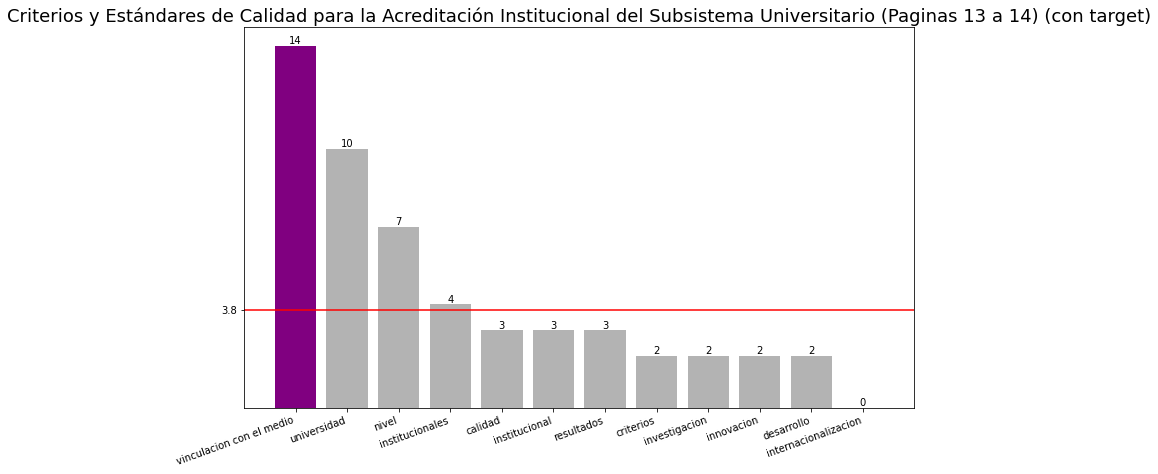

In [5]:
task = [{'file': 'CyE INSTITUCIONAL SUBSISTEMA UNIVERSITARIO_NUEVO.pdf', 'target': True, 'pages': [13, 14],
        'title': 'Criterios y Estándares de Calidad para la Acreditación Institucional del Subsistema Universitario (Paginas 13 a 14) (con target)', 'special_cases': special_cases}]

for t in task:
    pdf = ReadPDF(**t)
    words = pdf(**t)
    plot_words(words,
           title=t['title'],
           special_cases=pdf.special_counter,
           target=t['target'],
           target_words=target_words)

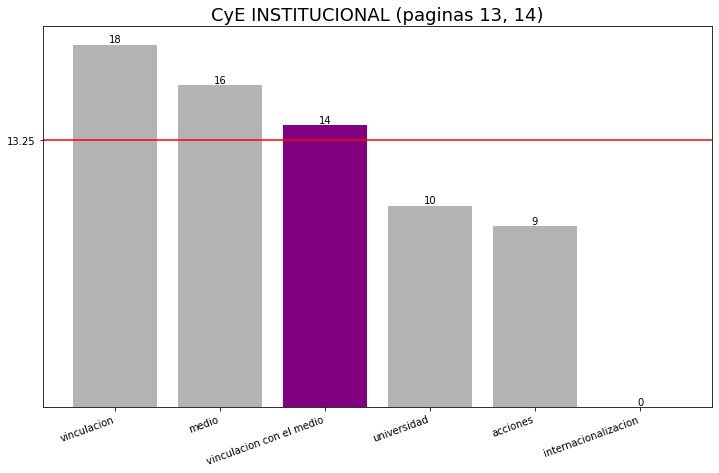

In [6]:
task = [{'file': 'CyE INSTITUCIONAL SUBSISTEMA UNIVERSITARIO_NUEVO.pdf', 'target': False, 'pages': [13, 14],
        'title': 'CyE INSTITUCIONAL (paginas 13, 14)', 'special_cases': special_cases}]

for t in task:
    pdf = ReadPDF(**t)
    words = pdf(**t)
    plot_words(words,
           title=t['title'],
           special_cases=pdf.special_counter,
           target=t['target'],
           target_words=target_words)

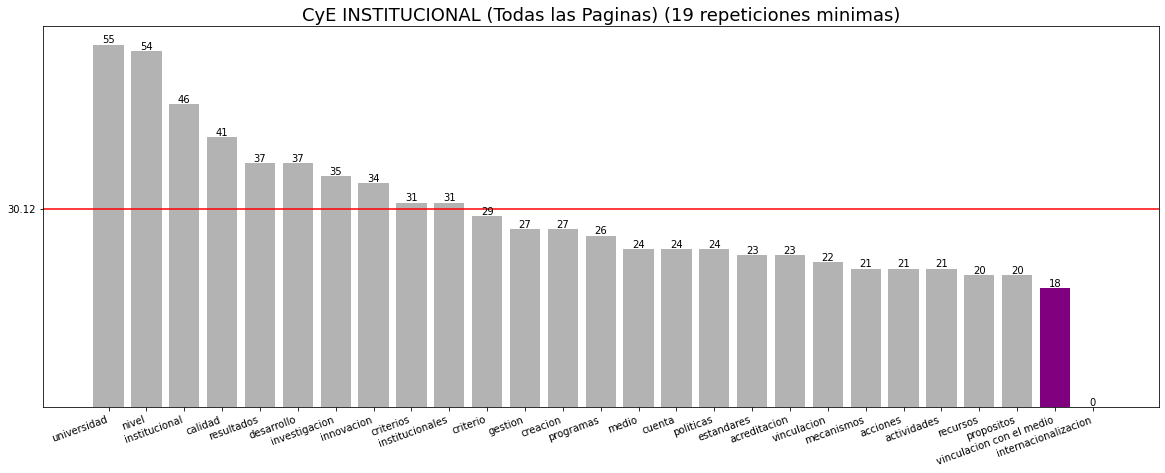

In [7]:
task = [{'file': 'CyE INSTITUCIONAL SUBSISTEMA UNIVERSITARIO_NUEVO.pdf', 'target': False, 'repetitions':19, 
        'title': 'CyE INSTITUCIONAL (Todas las Paginas) (19 repeticiones minimas)', 'special_cases': special_cases}]

for t in task:
    pdf = ReadPDF(**t)
    words = pdf(**t)
    plot_words(words,
           title=t['title'],
           special_cases=pdf.special_counter,
           target=t['target'],
           target_words=target_words,
           repetitions=t['repetitions'], figsize=(20, 7))

# Transcripcion

In [ ]:
path = 'Transcripcion'

special_cases = ['vinculacion con el medio']

task = [{'file': 'plan_estrategico_institucional_2020_2025_v11_2021.pdf', 'target': True,
         'title': 'Universidad Arturo Prat', 'special_cases': special_cases},]

files = [f for file in os.listdir(path) if f.endswith('pdf')]
tasks = []
for file in files:
    path2file = os.path.join(path, file)
    title = file.split('_')[-1].split('.')[1]
    tasks.append({'file': path2filefile, 'target': False, 'title': title})
    
    
for t in tasks:
    pdf = ReadPDF(**t)
    words = pdf(**t)
    plot_words(words,
               title=t['title'],
               special_cases=pdf.special_counter,
               target=t['target'],
               target_words=target_words)   